# Follow Jeremy's first hour of Lesson 2, oldversion

In [68]:
# verify we are in the lesson1 dir
%pwd
%ll '/home/ubuntu/data/redux'

total 835816
drwxrwxr-x 4 ubuntu      4096 Apr 15 10:06 results/
drwxrwxr-x 6 ubuntu      4096 Apr 15 08:53 sample/
-rw-rw-r-- 1 ubuntu    113903 Apr 15 08:17 sample_submission.csv
-rw-rw-r-- 1 ubuntu    163903 Apr 15 10:11 subm98.csv
drwxr-xr-x 3 ubuntu    299008 Apr 15 08:58 test/
-rw-rw-r-- 1 ubuntu 284478493 Apr 15 08:17 test.zip
drwxr-xr-x 4 ubuntu    802816 Apr 15 08:58 train/
-rw-rw-r-- 1 ubuntu 569918665 Apr 15 08:17 train.zip
drwxrwxr-x 4 ubuntu     69632 Apr 15 08:58 valid/


In [66]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = '/home/ubuntu/data/redux'

In [6]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Action plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective dir
3. Finetune and train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

# Create Validation set and sample

In [7]:
# create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train sample/test sample/valid sample/results
%mkdir -p test/unknown

/home/ubuntu/data/redux


In [8]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/data/redux/train


In [12]:
g = glob('*.jpg') # cool function to get all name from regex
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [13]:
from shutil import copyfile
g = glob('*.jpg')
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [15]:
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

/home/ubuntu/data/redux/valid


In [16]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/data/redux/sample/train
/home/ubuntu/data/redux/sample/valid
/home/ubuntu/data/redux/valid
/home/ubuntu/data/redux/train


In [17]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/data/redux/test


In [45]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/data/redux


In [19]:
#import Vgg16 helper class
vgg = Vgg16()

16384/35363 [============>.................] - ETA: 0s

In [21]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=256
no_of_epochs=1

In [22]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [23]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 780s - loss: 0.3721 - acc: 0.9697 - val_loss: 0.2935 - val_acc: 0.9790
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 784s - loss: 0.3154 - acc: 0.9767 - val_loss: 0.3124 - val_acc: 0.9765
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 785s - loss: 0.3173 - acc: 0.9781 - val_loss: 0.3240 - val_acc: 0.9775
Completed 3 fit operations


In [106]:
vgg.model.save_weights(path+'results/ft1.h5')

In [46]:
batches, preds = vgg.test(path+'/test', batch_size=batch_size*2)
filenames = batches.filenames
preds[:5]
filenames[:5]
print(preds)

Found 12500 images belonging to 1 classes.


KeyboardInterrupt: 

In [55]:
save_array(path+'results/test_preds.dat', preds)
save_array(path+'results/filenames.dat', filenames)

In [56]:
preds = load_array(path+'results/test_preds.dat')
filenames = load_array(path+'results/filenames.dat')
print('done')

LookupError: unknown encoding: hex

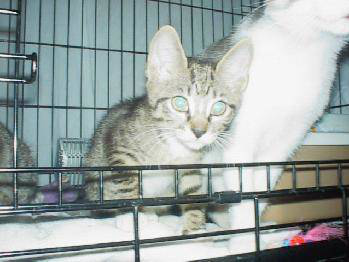

In [57]:
from PIL import Image
Image.open('test/'+filenames[0])

In [58]:
isdog = preds[:,1]
isdog[:5]

array([  0.0000e+00,   2.7539e-38,   0.0000e+00,   0.0000e+00,   1.0000e+00], dtype=float32)

In [59]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [60]:
subm = np.stack([ids, isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   0.0000e+00],
       [  1.2026e+04,   2.7539e-38],
       [  9.6880e+03,   0.0000e+00],
       [  4.3920e+03,   0.0000e+00],
       [  7.7900e+02,   1.0000e+00]])

In [61]:
np.savetxt(DATA_HOME_DIR+'/subm98.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [72]:
from IPython.display import FileLink
np.savetxt('/home/ubuntu/git/courses/deeplearning1/nbs/subm98.csv', subm, fmt='%d,%.5f', header='id,label', comments='')
# FileLink(DATA_HOME_DIR+'/subm98.csv')
FileLink('./subm98.csv')

/home/ubuntu/data/redux/subm98.csv

In [76]:
# clip first before saving:
isdog = np.clip(preds[:,1], 0.05, 0.95)
subm95 = np.stack([ids, isdog], axis=1)
np.savetxt('/home/ubuntu/git/courses/deeplearning1/nbs/subm95.csv', subm95, fmt='%d,%.5f', header='id,label', comments='')


# Visualizing results
Keras .fit() function conveniently shows us the value of the loss function, and the accuracy, after every epoch. Epoch = one full run through all training examples.
The most important metrics for us to look at are for the validation set.

## Additional examples outside overall metrics
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (correct ones with highest probabilities)
4. The most incorrect labels of each class (i.e. ones with highest probabilities that are incorrect)
5. The most uncertain labels (probabilities closest to 0.5)
KEEP THIS PROCESS AROUND SOMEWHERE!

Calculate predictions on the validation set, so we can find correct and incorrect examples:

In [107]:
vgg.model.load_weights(path+'results/ft1.h5')

In [108]:
val_batches, probs = vgg.test(path+'valid', batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [109]:
labels=val_batches.classes
filenames=val_batches.filenames

In [110]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[:8]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [111]:
preds[:8]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [112]:
# number of iamges to view for each visualization task
n_view = 4

# helper function to plot images by index in valid set
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/' + filenames[i]) for i in idx], titles=titles)

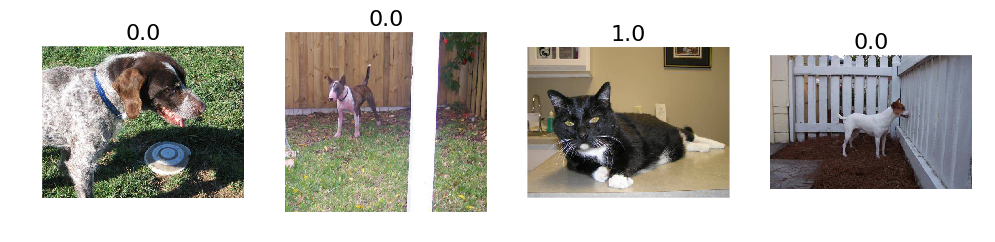

In [113]:
# 1. a few correct labels at random
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

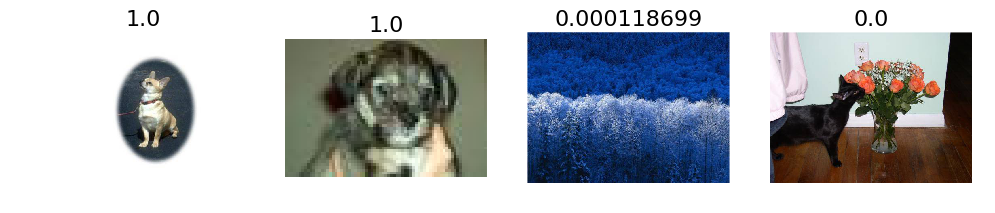

In [114]:
# 2. a few incorrect labels at random
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

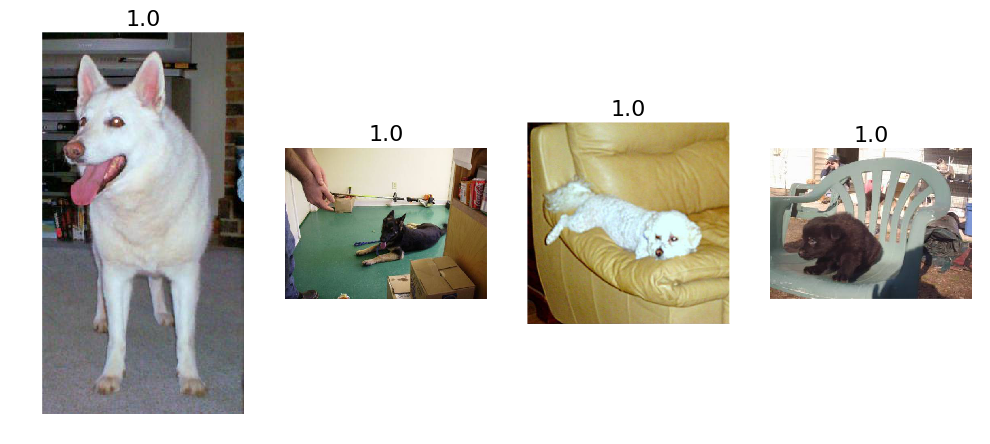

In [115]:
# 3. The images that we are most confident were cats, but are dogs
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
idx = permutation(correct)[:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])



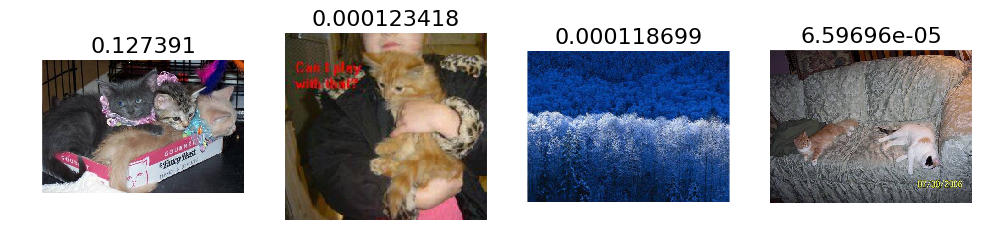

In [116]:
# 3. The images that we are most confident were dogs, but are not
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])



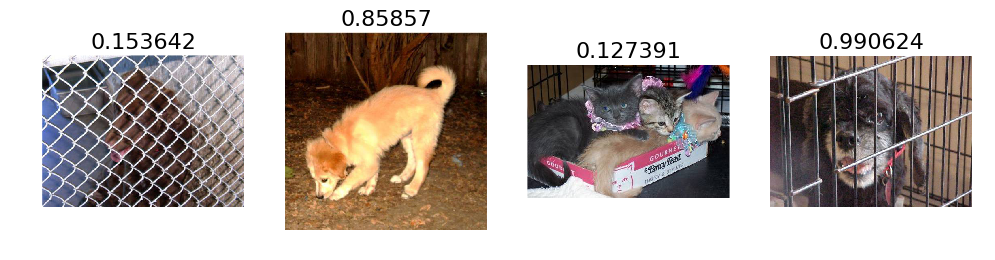

In [117]:
# 5. Most uncertain
most_uncertain = np.argsort(np.abs(probs-0.5))
most_uncertain_top = most_uncertain[:n_view]
plots_idx(most_uncertain_top, probs[most_uncertain_top])

array([3, 0, 1, 2])